In [2]:
# Import the necessary libraries
import pandas as pd
import numpy as np
from scipy import stats
import pmdarima as pmd
import matplotlib.pyplot as plt
import pybats
from pybats.loss_functions import MAPE
from pybats.analysis import analysis
from pybats.point_forecast import median
import math


In [3]:
# import the data
dfv = pd.read_csv("solar_clean_data.csv")

In [4]:
dfv.head()

,Date,Total Generation (KWH),Insolation,Grid Failure,Inverter,Module Cleaning,Rainy day,Transformer replacement and maintenance,Cable and Fuse maintenance,Plant Shutdown,Internet,Battery,Cloudy
0,06-07-2012,3218.0,9.37536,1,0,0,0,0,0,0,0,0,0
1,07-07-2012,3633.0,9.37536,1,0,0,0,0,0,0,0,0,0
2,08-07-2012,4377.0,9.37536,0,1,0,0,0,0,0,0,0,0
3,09-07-2012,4625.0,9.37536,0,1,0,0,0,0,0,0,0,0
4,10-07-2012,648.0,9.37536,0,1,0,0,0,0,0,0,0,0


In [5]:
dfv.columns

Index(['Date', 'Total Generation (KWH)', 'Insolation', 'Grid Failure',
       'Inverter', 'Module Cleaning', 'Rainy day',
       'Transformer replacement and maintenance', 'Cable and Fuse maintenance',
       'Plant Shutdown', 'Internet', 'Battery', 'Cloudy'],
      dtype='object')

In [6]:
# dfv=dfv[['Date', 'Total Generation (KWH)', 'Insolation', 'Grid Failure','Inverter', 'Module Cleaning', 'Rainy day','Cloudy']]

In [7]:
dfv.iloc[:,2:]

,Insolation,Grid Failure,Inverter,Module Cleaning,Rainy day,Transformer replacement and maintenance,Cable and Fuse maintenance,Plant Shutdown,Internet,Battery,Cloudy
0,9.37536,1,0,0,0,0,0,0,0,0,0
1,9.37536,1,0,0,0,0,0,0,0,0,0
2,9.37536,0,1,0,0,0,0,0,0,0,0
3,9.37536,0,1,0,0,0,0,0,0,0,0
4,9.37536,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2365,5.74700,1,0,1,0,0,0,0,0,0,0
2366,5.68900,0,0,1,0,0,0,0,0,0,0
2367,5.83400,1,0,1,0,0,0,0,0,0,0
2368,5.58400,0,1,0,0,0,0,0,0,0,0


In [8]:
def bayes_forecast(iv,dv):
    '''
    This functions runs the Pybats algorithm by taking two parameters: an independent variable matrix and a dependent variable. 
    Both elements must be sequential time series. 
    '''
    # first check if the iv = None, indicating this would be a univariate series
    x = None if iv is None else iv.values
    y = dv.values

    # set the one-step-ahead value; by default we want 1
    k = 1
    forecast_start = 0
    forecast_end = len(y)-1
    mod, samples = analysis(Y=y, X=x, family='poisson',
       forecast_start=forecast_start,      
       forecast_end=forecast_end,         
       k=k,                                
       ntrend=1,
       nsamps=5000,
       seasPeriods=[12],
       seasHarmComponents=[[1,2]],
       prior_length=4,                     
       deltrend=0.94,                      
       delregn=0.90,                        
       delVar=0.98,
       delSeas=0.98,
       rho=.6,
       )
    forecast = median(samples)

    # set confidence interval for in-sample forecast
    credible_interval=95
    alpha = (100-credible_interval)/2
    upper=np.percentile(samples, [100-alpha], axis=0).reshape(-1)
    lower=np.percentile(samples, [alpha], axis=0).reshape(-1)
    # calculating mape
    print("MAPE:", MAPE(y[-18:], forecast[-18:]).round(2))
    # calculating mse
    mse = np.square(np.subtract(y[-18:],forecast[-18:])).mean()
    print("MSE:",mse)
    # calculating rmse
    print("RMSE:",math.sqrt(mse))


    #Generate the Bayesian Future Forecast
    return mod, forecast, samples, y
mv_mod, mv_for, mv_samp, mv_y = bayes_forecast(dfv.iloc[:,2:4], dfv['Total Generation (KWH)'])

MAPE: 8.29
MSE: 269555.14030432096
RMSE: 519.1869993598848


In [9]:
# Calculate Bayesian estimate for the univariate model
uv_mod, uv_for, uv_samp, uv_y = bayes_forecast(None, dfv['Total Generation (KWH)'])

MAPE: 10.66
MSE: 216842.57669320988
RMSE: 465.6635874676158


In [10]:
#dfv.iloc[:,2:]
# Calculate Bayesian estimate for the multivariate model
uv_mod, uv_for, uv_samp, uv_y = bayes_forecast(dfv.iloc[:,2:], dfv['Total Generation (KWH)'])


MAPE: 37.61
MSE: 13588577.452835185
RMSE: 3686.268771106522


In [11]:
dfv.columns

Index(['Date', 'Total Generation (KWH)', 'Insolation', 'Grid Failure',
       'Inverter', 'Module Cleaning', 'Rainy day',
       'Transformer replacement and maintenance', 'Cable and Fuse maintenance',
       'Plant Shutdown', 'Internet', 'Battery', 'Cloudy'],
      dtype='object')

In [12]:
uv_mod, uv_for, uv_samp, uv_y = bayes_forecast(dfv[['Grid Failure', 'Module Cleaning', 'Rainy day', 'Cloudy']], dfv['Total Generation (KWH)'])

MAPE: 10.55
MSE: 224791.18172407406
RMSE: 474.12148414101006


In [13]:
uv_mod, uv_for, uv_samp, uv_y = bayes_forecast(dfv[['Grid Failure', 'Module Cleaning','Cloudy']], dfv['Total Generation (KWH)'])


d:\Python 3.10.7\lib\site-packages\statsmodels\regression\_tools.py:121: RuntimeWarning: divide by zero encountered in double_scalars
  scale = np.dot(wresid, wresid) / df_resid


MAPE: 10.6
MSE: 224880.3751808642
RMSE: 474.2155366295628


### Factors

Printing data preview ------>
          Date  Total Generation (KWH)  Insolation  Grid Failure  Inverter  \
0  2012-07-06                 3218.00     9.37536             1         0   
1  2012-07-07                 3633.00     9.37536             1         0   
2  2012-07-08                 4377.00     9.37536             0         1   
3  2012-07-09                 4625.00     9.37536             0         1   
4  2012-07-10                  648.00     9.37536             0         1   
5  2012-07-11                 3012.00     9.37536             0         1   
6  2012-07-12                 3545.00     9.37536             0         1   
7  2012-07-13                 3100.93     9.37536             0         1   
8  2012-07-14                 2940.03     4.72300             0         1   
9  2012-07-15                 3357.00     3.94200             1         0   

   Module Cleaning  Rainy day  No Module Cleaning  \
0                0          0                   0   
1              

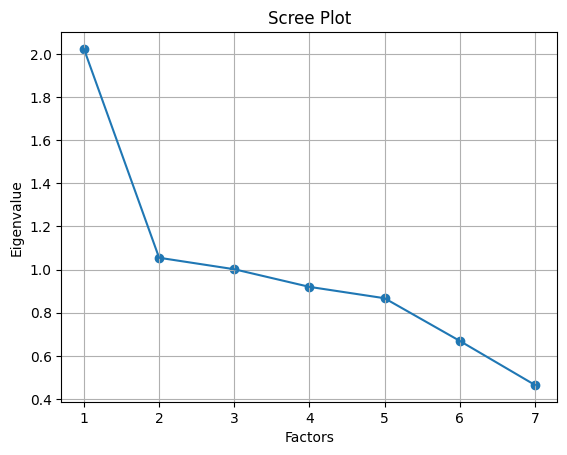

factors:
 [[ 9.60369537e-04  7.91474304e-03  3.58093641e-03]
 [ 1.86083734e-01  9.80218350e-01  4.19901959e-02]
 [-4.97438466e-01 -2.15293978e-01 -3.41426923e-01]
 [-1.03962300e-02  4.08493640e-02  3.70194066e-01]
 [-2.15383231e-01 -2.01313742e-01  8.40854785e-02]
 [ 9.08458812e-01  4.76105034e-03 -5.71788212e-02]
 [ 3.33717072e-01  2.82299463e-01  3.07789846e-02]]
                         factor1   factor2   factor3
Insolation              0.000960  0.007915  0.003581
Inverter                0.186084  0.980218  0.041990
Total Generation (KWH) -0.497438 -0.215294 -0.341427
Grid Failure           -0.010396  0.040849  0.370194
Module Cleaning        -0.215383 -0.201314  0.084085
Cloudy                  0.908459  0.004761 -0.057179
Rainy day               0.333717  0.282299  0.030779
                 factor1   factor2   factor3
SS Loadings     1.265236  1.129154  0.266679
Proportion Var  0.180748  0.161308  0.038097
Cumulative Var  0.180748  0.342056  0.380153
communalities:
 [7.63885727e

In [14]:
import latent_factor as lf

In [15]:
dam = lf.load_data(data='solar_clean_data.csv',take_only=['Insolation','Inverter','Total Generation (KWH)','Grid Failure','Module Cleaning','Cloudy','Rainy day'])
dam

Printing data preview ------>
          Date  Total Generation (KWH)  Insolation  Grid Failure  Inverter  \
0  06-07-2012                 3218.00     9.37536             1         0   
1  07-07-2012                 3633.00     9.37536             1         0   
2  08-07-2012                 4377.00     9.37536             0         1   
3  09-07-2012                 4625.00     9.37536             0         1   
4  10-07-2012                  648.00     9.37536             0         1   
5  11-07-2012                 3012.00     9.37536             0         1   
6  12-07-2012                 3545.00     9.37536             0         1   
7  13-07-2012                 3100.93     9.37536             0         1   
8  14-07-2012                 2940.03     4.72300             0         1   
9  15-07-2012                 3357.00     3.94200             1         0   

   Module Cleaning  Rainy day  Transformer replacement and maintenance  \
0                0          0                  

,Insolation,Inverter,Total Generation (KWH),Grid Failure,Module Cleaning,Cloudy,Rainy day
0,9.37536,0,3218.00,1,0,0,0
1,9.37536,0,3633.00,1,0,0,0
2,9.37536,1,4377.00,0,0,0,0
3,9.37536,1,4625.00,0,0,0,0
4,9.37536,1,648.00,0,0,0,0
...,...,...,...,...,...,...,...
2365,5.74700,0,4129.29,1,1,0,0
2366,5.68900,0,4266.50,0,1,0,0
2367,5.83400,0,3732.03,1,1,0,0
2368,5.58400,1,4063.88,0,0,0,0


chi square value: 1500.7627919775493
p value: 2.3981106477703127e-305
calculated kmo: 0.6204164728255777
eigen values: [2.02283716 1.0546645  1.00140363 0.91970378 0.86699092 0.66932862
 0.4650714 ]


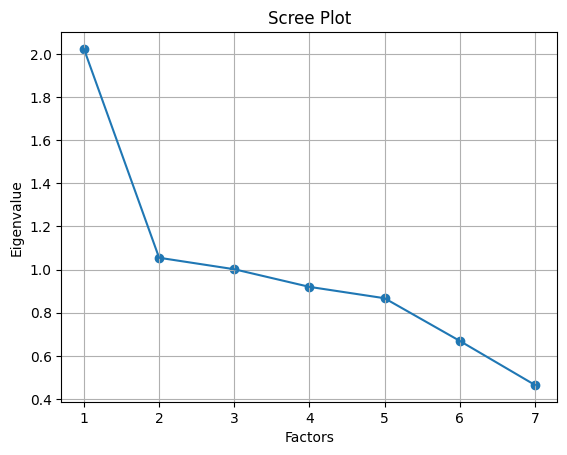

factors:
 [[ 9.60369123e-04  7.91474125e-03  3.58094814e-03]
 [ 1.86083712e-01  9.80218351e-01  4.19903091e-02]
 [-4.97438460e-01 -2.15293946e-01 -3.41427030e-01]
 [-1.03962477e-02  4.08493274e-02  3.70193989e-01]
 [-2.15383232e-01 -2.01313753e-01  8.40854458e-02]
 [ 9.08458794e-01  4.76108235e-03 -5.71787897e-02]
 [ 3.33717061e-01  2.82299459e-01  3.07790308e-02]]
                         factor1   factor2   factor3
Insolation              0.000960  0.007915  0.003581
Inverter                0.186084  0.980218  0.041990
Total Generation (KWH) -0.497438 -0.215294 -0.341427
Grid Failure           -0.010396  0.040849  0.370194
Module Cleaning        -0.215383 -0.201314  0.084085
Cloudy                  0.908459  0.004761 -0.057179
Rainy day               0.333717  0.282299  0.030779
                 factor1   factor2   factor3
SS Loadings     1.265236  1.129154  0.266679
Proportion Var  0.180748  0.161308  0.038097
Cumulative Var  0.180748  0.342056  0.380153
communalities:
 [7.63886274e

(array([[ 9.60369123e-04,  7.91474125e-03,  3.58094814e-03],
        [ 1.86083712e-01,  9.80218351e-01,  4.19903091e-02],
        [-4.97438460e-01, -2.15293946e-01, -3.41427030e-01],
        [-1.03962477e-02,  4.08493274e-02,  3.70193989e-01],
        [-2.15383232e-01, -2.01313753e-01,  8.40854458e-02],
        [ 9.08458794e-01,  4.76108235e-03, -5.71787897e-02],
        [ 3.33717061e-01,  2.82299459e-01,  3.07790308e-02]]),
                          factor1   factor2   factor3
 Insolation              0.000960  0.007915  0.003581
 Inverter                0.186084  0.980218  0.041990
 Total Generation (KWH) -0.497438 -0.215294 -0.341427
 Grid Failure           -0.010396  0.040849  0.370194
 Module Cleaning        -0.215383 -0.201314  0.084085
 Cloudy                  0.908459  0.004761 -0.057179
 Rainy day               0.333717  0.282299  0.030779,
                  factor1   factor2   factor3
 SS Loadings     1.265236  1.129154  0.266679
 Proportion Var  0.180748  0.161308  0.038097


In [16]:
lf.factor(dam)

## Arima

In [17]:
dfv_train = dfv[:-12]
dfv_test = dfv[-12:]
dfv_test

,Date,Total Generation (KWH),Insolation,Grid Failure,Inverter,Module Cleaning,Rainy day,Transformer replacement and maintenance,Cable and Fuse maintenance,Plant Shutdown,Internet,Battery,Cloudy
2358,20-12-2018,4103.56,5.511,0,0,1,0,1,0,0,0,0,0
2359,21-12-2018,4175.58,5.700,1,0,1,0,0,0,0,0,0,0
2360,22-12-2018,3809.72,5.335,1,0,1,0,0,0,0,0,0,0
2361,23-12-2018,3942.46,5.482,1,0,0,0,0,0,0,0,0,0
2362,24-12-2018,2923.51,5.171,1,0,1,0,0,0,0,0,0,0
2363,25-12-2018,3970.89,5.276,0,0,1,0,0,0,0,0,0,0
2364,26-12-2018,4012.14,5.219,0,0,1,0,0,0,0,0,0,0
2365,27-12-2018,4129.29,5.747,1,0,1,0,0,0,0,0,0,0
2366,28-12-2018,4266.50,5.689,0,0,1,0,0,0,0,0,0,0
2367,29-12-2018,3732.03,5.834,1,0,1,0,0,0,0,0,0,0


In [18]:
mod = pmd.auto_arima(y=dfv_train['Total Generation (KWH)'], exogenous=dfv_train.iloc[:,2:4], stepwise=True, m=12, seasonal=True)
y_pred = mod.predict_in_sample(exogenous=dfv_train.iloc[:,2:4], return_conf_int=True, alpha=0.05)
a_low = y_pred[1][:,0]
a_high = y_pred[1][:,1]
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2358
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -18785.799
Date:                Thu, 09 Mar 2023   AIC                          37577.597
Time:                        10:23:55   BIC                          37594.893
Sample:                             0   HQIC                         37583.895
                               - 2358                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4695      0.018     26.554      0.000       0.435       0.504
ma.L1         -0.8987      0.011    -81.601      0.000      -0.920      -0.877
sigma2      4.899e+05   8384.714     58.429      0.000    4.73e+05    5.06e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1803.70
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -0.94
Prob(H) (two-sided):                  0.61   Kurtosis:                         6.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
y_pred[0]

0          0.000000
1       2905.539743
2       3285.475375
3       3864.034912
4       4118.426820
           ...     
2353    3626.148820
2354    3688.669216
2355    3424.843727
2356    3589.912778
2357    3821.275697
Length: 2358, dtype: float64

In [20]:
err = list(dfv['Total Generation (KWH)'][12:]) - y_pred[0][:]
err

0       3689.000000
1        394.470257
2        509.524625
3       -166.034912
4      -1556.326820
           ...     
2353     503.141180
2354     577.830784
2355     307.186273
2356     473.967222
2357     272.624303
Length: 2358, dtype: float64

In [21]:
li=[dfv['Total Generation (KWH)'][12:]]
li

[12      3689.00
 13      3300.01
 14      3795.00
 15      3698.00
 16      2562.10
          ...   
 2365    4129.29
 2366    4266.50
 2367    3732.03
 2368    4063.88
 2369    4093.90
 Name: Total Generation (KWH), Length: 2358, dtype: float64]

In [22]:
o = li
f = y_pred[0]
print(100*np.mean(np.abs((o - f)) / o))

ValueError: Length of values (1) does not match length of index (2358)

In [ ]:
# calculating mape
print("MAPE:", MAPE(list(dfv['Total Generation (KWH)'][12:]), y_pred[0][:]).round(2))
# calculating mse
mse = np.square(np.subtract(list(dfv['Total Generation (KWH)'][12:]), y_pred[0][:])).mean()
print("MSE:",mse)
# calculating rmse
print("RMSE:",math.sqrt(mse))

MAPE: inf
MSE: 997153.2947073295
RMSE: 998.5756329429081


c:\Users\Rajeshsingh\AppData\Local\Programs\Python\Python39\lib\site-packages\pybats\loss_functions.py:36: RuntimeWarning: divide by zero encountered in true_divide
  return 100*np.mean(np.abs((y - f)) / y)
